Descargado: /content/data/mes_ensemble_pp_peru.nc
Descargado: /content/data/prom.pp.clima.nc
Descargado: /content/data/DEPARTAMENTOS.shp
Descargado: /content/data/DEPARTAMENTOS.dbf
Descargado: /content/data/DEPARTAMENTOS.shx
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.shp
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.dbf
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.shx
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.shp
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.dbf
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.shx
Verificado: /content/data/DEPARTAMENTOS.shp
Verificado: /content/data/DEPARTAMENTOS.dbf
Verificado: /content/data/DEPARTAMENTOS.shx
Gráfico guardado en: /content/figuras/pre_smnwrf_2024120102_anomPrec_wrf.png


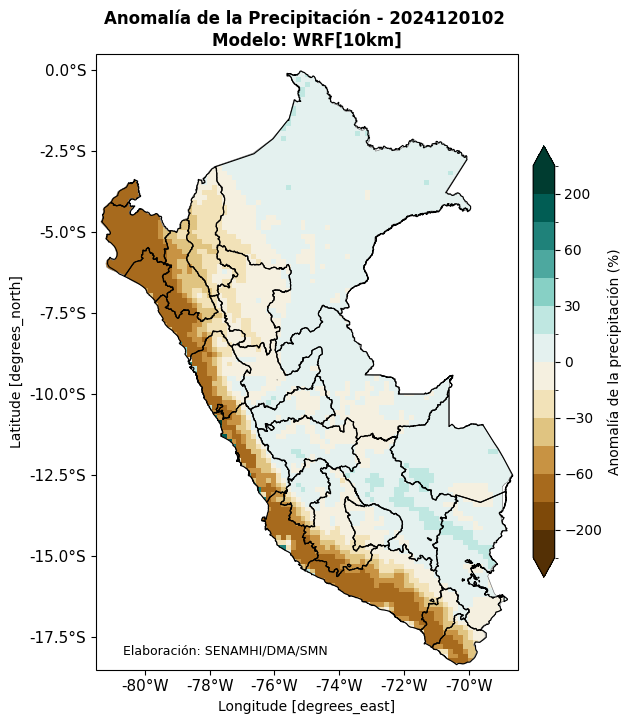

In [19]:
# Instalar librerías necesarias
!pip install geopandas cartopy xarray matplotlib cftime pandas

import os
import requests
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

# Descargar archivos
def download_file(url, local_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(local_path, 'wb') as f:
            f.write(response.content)
        print(f"Descargado: {local_path}")
    else:
        print(f"Error al descargar {url}: {response.status_code}")

# Rutas de descarga
files = {
    "archivo_pronostico": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data/mes_ensemble_pp_peru.nc",
    "archivo_climatologia": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data/prom.pp.clima.nc",
    "peru_shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "peru_dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "peru_shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx",
    "sudamerica_shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shp",
    "sudamerica_dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.dbf",
    "sudamerica_shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shx"
}

# Descargar y preparar archivos
local_dir = "/content/data"
os.makedirs(local_dir, exist_ok=True)
local_files = {}
for name, url in files.items():
    local_path = os.path.join(local_dir, os.path.basename(url))
    download_file(url, local_path)
    local_files[name] = local_path

# Verificar que todos los archivos de shapefile están presentes
def verify_shapefile(base_name):
    for ext in ['.shp', '.dbf', '.shx']:
        file_path = base_name + ext
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Archivo necesario no encontrado: {file_path}")
        print(f"Verificado: {file_path}")

verify_shapefile(os.path.join(local_dir, "SUDA_NUEVO_SIN_PERU_3"))
verify_shapefile(os.path.join(local_dir, "DEPARTAMENTOS"))

# Rutas de archivos descargados
archivo_pronostico = local_files["archivo_pronostico"]
archivo_climatologia = local_files["archivo_climatologia"]
ruta_shapefile_peru = os.path.join(local_dir, "DEPARTAMENTOS.shp")
ruta_shapefile_sudamerica = os.path.join(local_dir, "SUDA_NUEVO_SIN_PERU_3.shp")

# Cargar shapefiles
peru = gpd.read_file(ruta_shapefile_peru)
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)

# Verificar si el CRS coincide y transformar si es necesario
if sudamerica.crs != peru.crs:
    print("Transformando CRS de Sudamérica al CRS de Perú.")
    sudamerica = sudamerica.to_crs(peru.crs)

# Abrir los archivos NetCDF
ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)

# Extraer la fecha base desde los atributos de 'time'
time_units = ds_pronostico['time'].attrs['units']
fecha_base_str = time_units.split('since')[-1].strip()
fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

# Acceder a las variables de precipitación
pronostico_lluvia = ds_pronostico['p']
climatologia_lluvia = ds_climatologia['p']

# Definir niveles para anomalías
niveles = np.concatenate([np.arange(-300, -60, 100), np.arange(-60, 61, 15), np.arange(100, 301, 100)])
norm = BoundaryNorm(niveles, ncolors=256)

# Calcular el promedio trimestral
pronostico_lluvia_trimestre = pronostico_lluvia.isel(time=slice(0, 3)).mean(dim='time')
climatologia_lluvia_trimestre = climatologia_lluvia.isel(time=slice(0, 3)).mean(dim='time')
anomalia_porcentual_lluvia_trimestre = ((pronostico_lluvia_trimestre - climatologia_lluvia_trimestre) / climatologia_lluvia_trimestre) * 100

# Calcular fechas correspondientes
fechas_reales = [add_months_to_date(fecha_base, int(ds_pronostico['time'].isel(time=i).values)) for i in range(3)]
fecha_str = f"{fechas_reales[0].year}{fechas_reales[0].month:02d}{fechas_reales[1].month:02d}{fechas_reales[2].month:02d}"

# Crear carpeta para guardar los gráficos
ruta_carpeta = "/content/figuras"
os.makedirs(ruta_carpeta, exist_ok=True)

# Graficar anomalía porcentual
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Configuración de límites geográficos
lon_min, lon_max = -81.5, -68.5
lat_min, lat_max = -18.5, 0.5

img = anomalia_porcentual_lluvia_trimestre.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', norm=norm, add_colorbar=False)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Aplicar shapefile de departamentos de Perú
peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Aplicar shapefile de Sudamérica sin Perú
#sudamerica.boundary.plot(ax=ax, edgecolor='red', linewidth=0.4)
sudamerica.plot(ax=ax, edgecolor='grey', facecolor='white', linewidth=0.4, zorder=1)

# Barra de colores
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, extend='both', shrink=0.7, aspect=20)
cbar.set_label('Anomalía de la precipitación (%)')

# Configurar etiquetas
ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
ax.tick_params(axis='both', which='major', labelsize=11)

# Título y leyenda
ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right', verticalalignment='bottom',
        transform=ax.transAxes, fontsize=9, color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
plt.title(f'Anomalía de la Precipitación - {fecha_str} \nModelo: WRF[10km]', fontsize=12, fontweight='bold')

# Guardar el gráfico
nombre_archivo = f"pre_smnwrf_{fecha_str}_anomPrec_wrf.png"
ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')
print(f"Gráfico guardado en: {ruta_archivo}")

# Mostrar gráfico al final
plt.show()
